# LQR for Cart-Pole

In [1]:
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt

import gym
from collections import namedtuple

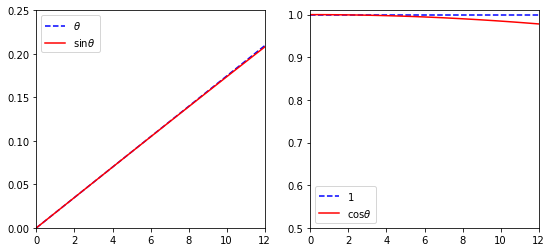

In [2]:
theta = np.linspace(0, 12, 100) /180*np.pi
t = np.ones(theta.shape[0])
y = np.sin(theta)
z = np.cos(theta)
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(121)
ax.plot(theta*180/np.pi, theta, 'b--', label=r'$\theta$')
ax.plot(theta*180/np.pi, y, 'r-', label=r'$\sin \theta$')
ax.set_ylim(0, 0.25)
ax.set_xlim(0, 12)
ax.legend()
ax = fig.add_subplot(122)
ax.plot(theta*180/np.pi, t, 'b--', label=r'$1$')
ax.plot(theta*180/np.pi, z, 'r-', label=r'$\cos \theta$')
ax.set_ylim(0.5, 1.01)
ax.set_xlim(0, 12)
ax.legend(loc=3)
plt.show()

## State-Space Model
* [GYM model](https://coneural.org/florian/papers/05_cart_pole.pdf)
    * neglect friction
    * $\theta$ is the deviation angle from the equilibrium
    * $F$ is the applied force to the cart
    * the pole has a mass $m_p$ and length $2\ell$
    * the cart has a mass $m_c$
    * $s = [x, \dot{x}, \theta, \dot{\theta}]^T$, $\mu \in \{ -F, +F\}$
$$
\ddot{\theta} = \frac{g \sin \theta + \cos \theta (\frac{-F - m_p \ell \dot{\theta}^2 \sin \theta}{m_c + m_p})}{\ell (\frac{4}{3} - \frac{m_p \cos^2 \theta}{m_c+m_p})},\
\ddot{x} = \frac{F + m_p \ell (\dot{\theta}^2 \sin \theta - \ddot{\theta} \cos \theta)}{m_c + m_p} 
$$

* [http://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=SystemModeling](http://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=SystemModeling)
    * when $\theta$ is small, $\sin \theta \approx \theta$, $\cos \theta \approx 1$, $\dot{\theta}^2 \approx 0$ -> linear approximation
$$
\ddot{\theta} \approx \frac{g \theta + \frac{-F}{m_c + m_p}}{\ell (\frac{4}{3} - \frac{m_p}{m_c+m_p})} =: w_\theta \theta + w_F F,\
\ddot{x} \approx \frac{F - m_p \ell \ddot{\theta}}{m_c + m_p} = \frac{- m_p \ell w_\theta}{m_c + m_p} \theta + \frac{1 - m_p \ell w_F}{m_c + m_p} F
$$

* LQR, CT, Infinite Horizon
    * $J(s, \mu) = \frac{1}{2} c_x s[0]^2 +  \frac{1}{2} c_\theta s[2]^2 + \frac{1}{2} c_\mu \mu^2$
    * $0 = A^TP + PA - PBR^{-1}B^TPQ$ (CARE)
    * $\mu = K s = -R^{-1}B^TP s$

In [3]:
#== Param ==
gravity = 9.8
masscart = 1.0
masspole = 0.1
length = 0.5  # actually half the pole's length

In [4]:
def cart_pole_sys(c_x=1, c_theta=1, c_mu=1, masscart=1., masspole=0.1, length=0.5, gravity=9.8):
    total_mass = (masspole + masscart)
    polemass_length = (masspole * length)
    
    tmp = length * (4.0/3.0 + masspole/total_mass)
    w_theta = gravity / tmp
    w_F = -1 / total_mass / tmp

    A = np.zeros((4,4))
    B = np.zeros((4,1))
    Q = np.zeros((4,4))
    R = np.ones((1,1)) * c_mu
    
    A[0, 1] = 1.0
    A[2, 3] = 1.0
    A[3, 2] = w_theta
    A[1, 2] = -polemass_length / total_mass * w_theta
    B[3, 0] = w_F
    B[1, 0] = (1 - polemass_length * w_F) / total_mass
    Q[0, 0] = c_x
    Q[2, 2] = c_theta
    
    return A, B, Q, R

def LQR_inf_ct(A, B, Q, R):
    P = la.solve_continuous_are(A, B, Q, R)
    K = - la.inv(R) @ B.T @ P
    #print(P)
    #print(K)
    return K

## Environment

In [5]:
#== Cart Pole ==
# An episode ends when (1) |x| >= 2.4 (2) |theta| >= 12 deg (3) episode length > 200
env = gym.make('CartPole-v0')
env.seed(0)
s_dim = env.observation_space.shape[0]
print(s_dim)

running_reward_th = env.spec.reward_threshold
print(running_reward_th)

4
195.0


In [6]:
tmp_list = []
state_array = []
state_i = np.zeros((4,))
state_i[0] = 0.5
state_i[2] = 0.04
for c_theta in np.array([0.01, 0.1, 1, 10, 100]):
    ep_reward = 0
    env.reset()
    env.state = state_i
    s = state_i
    A, B, Q, R = cart_pole_sys(c_x=1, c_theta=c_theta)
    K = LQR_inf_ct(A, B, Q, R)
    done = False
    state_list = []
    while not done:
        #env.render()
        state_list.append(s[[0,2]])
        u = K @ s
        if u < 0:
            a = 0
        else:
            a = 1

        s_, r, done, _ = env.step(a)
        ep_reward += r
        s = s_
    print(ep_reward)
    tmp_list.append(ep_reward)
    state_array.append(state_list)
env.close()

200.0
200.0
200.0
200.0
200.0
